In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler 
import datetime
from sklearn.metrics import mean_squared_error
import math

import matplotlib.pyplot as plt
import tensorflow as tf

### Data Cleaning

In [2]:
df2 = pd.read_csv('tick.csv')
df2.rename(columns={'3':'Dates'},inplace=True)
df2.rename(columns={'17':'Tick_Street_Name'},inplace=True)
df2['date_column'] = pd.to_datetime(df2['Dates'],format ='%m/%d/%Y')

/home/ubuntu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (6,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [116]:
df2.rename(columns={'17':'Tick_Street_Name'},inplace=True)

In [134]:
Mission = df2[df2['Tick_Street_Name'] == 'MISSION']

In [145]:
Mission.head()

,Unnamed: 0,1,2,Dates,4,5,6,7,8,9,...,15,16,Tick_Street_Name,18,19,date_column,daily,year,month,year_daily
4,4,2016,1004040295,07/01/2016,21:45,7.0,000910,HOND,4D,NOT GIVEN,...,NaN,3018.0,MISSION,$288,NaN,2016-07-01,1,2016,7,"2016,7,1"
5,5,2016,1004040306,07/01/2016,22:25,7.0,000910,HOND,4D,NOT GIVEN,...,NaN,2331.0,MISSION,$183,NaN,2016-07-01,1,2016,7,"2016,7,1"
165,165,2016,865153984,07/01/2016,10:01,19.0,000129,HOND,2D,1HGEJ8142WL057019,...,NaN,4346.0,MISSION,$0,$231,2016-07-01,1,2016,7,"2016,7,1"
169,169,2016,865577753,07/01/2016,18:10,19.0,000183,CHEV,4D,CAN NOT READ,...,NaN,2301.0,MISSION,$0,$231,2016-07-01,1,2016,7,"2016,7,1"
245,245,2016,867034276,07/01/2016,06:01,19.0,000309,NISS,2D,CAN NOT READ,...,NaN,3172.0,MISSION,$144,NaN,2016-07-01,1,2016,7,"2016,7,1"


In [9]:
df2['daily'] = df2['date_column'].apply(lambda x: pd.Timestamp(x).day)
df2['daily'] = df2['daily'].apply(int).apply(str)
max(df2['daily'],key=(lambda x : int(x)))

#create a new column 'year'
df2['year'] = df2['date_column'].apply(lambda x: pd.Timestamp(x).year)
df2['year'] = df2['year'].apply(int).apply(str)

#create a new column 'month'
df2['month'] = df2['date_column'].apply(lambda x: pd.Timestamp(x).month)
df2['month'] = df2['month'].apply(int).apply(str)
max(df2['month'],key=(lambda x : int(x)))

#combined year and month and weekly to get daily per year
df2['year_daily']= df2['year'] + ',' + df2['month'] + ',' + df2['daily']
df2['year_daily'].max()

#count all the values in weekly per year
data_daily = df2['year_daily'].value_counts().sort_index()
data_daily.sum()
data_daily.shape

sub_data = data_daily[:140]
sub_data.shape
sub_data.max()

31

### Model

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


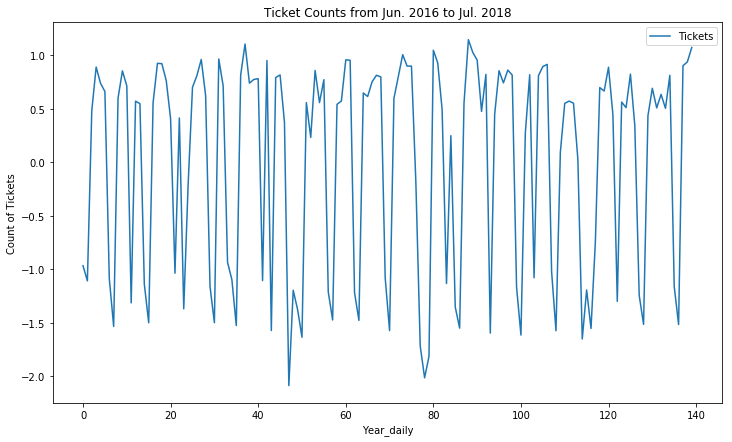

<Figure size 432x288 with 0 Axes>

In [26]:
#data preprocessing(scaling)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(sub_data.reshape(-1, 1))

#plotting the data
plt.figure(figsize=(12,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Ticket Counts from Jun. 2016 to Jul. 2018')
plt.xlabel('Year_daily')
plt.ylabel('Count of Tickets')
plt.plot(scaled_data, label='Tickets')
plt.legend()
plt.show()
plt.tight_layout()

In [61]:
# This function is used to create Features and Labels datasets. By windowing the data.
#Input: data - dataset used in the project
#window_size - how many data points we are going to use to predict the next datapoint in the sequence 
#[Example: if window_size = 1 we are going to use only the previous day to predict todays stock prices]
#Outputs: X - features splitted into windows of datapoints (if window_size = 1, X = [len(data)-1, 1])
#y - 'labels', actually this is the next number in the sequence, this number we are trying to predict

def window_data(data, window_size):
    X = []
    y = []
    
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
        i += 1
    assert len(X) ==  len(y)
    return X, y

#windowing the data with window_data function
X, y = window_data(scaled_data, 7)

In [62]:
#we now split the data into training and test set
import numpy as np
X_train  = np.array(X[:112])
y_train = np.array(y[:112])

X_test = np.array(X[112:])
y_test = np.array(y[112:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (112, 7, 1)
y_train size: (112, 1)
X_test size: (21, 7, 1)
y_test size: (21, 1)


In [63]:
#we now define the network
#Hyperparameters used in the network
batch_size = 7 #how many windows of data we are passing at once
window_size = 7 #how big window_size is (Or How many days do we consider to predict next point in the sequence)
hidden_layer = 256 #How many units do we use in LSTM cell
clip_margin = 4 #To prevent exploding gradient, we use clipper to clip gradients below -margin or above this margin
learning_rate = 0.001 
epochs = 300

In [64]:
#we define the placeholders
inputs = tf.placeholder(tf.float32, [batch_size, window_size,1])
targets = tf.placeholder(tf.float32, [batch_size,1])

In [65]:
#weights and implementation of LSTM cell
# LSTM weights

#Weights for the input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))

#weights for the forgot gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))

#weights for the output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

#weights for the memory cell
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

#Output layer weigts
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))
  

In [66]:
#function to compute the gate states
def LSTM_cell(input, output, state):
    
    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)
    
    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)
    
    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)
    
    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)
    
    state = state * forget_gate + input_gate * memory_cell
    
    output = output_gate * tf.tanh(state)
    return state, output

In [67]:
#we now define loop for the network
outputs = []
for i in range(batch_size): #Iterates through every window in the batch
  
    #for each batch I am creating batch_state as all zeros and output for that window which is all zeros at the beginning as well.
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32) 
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)
    
    #for each point in the window we are feeding that into LSTM to get next output
    for ii in range(window_size):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)
        
    #last output is conisdered and used to get a prediction
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)
outputs 

[<tf.Tensor 'add_952:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1016:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1080:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1144:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1208:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1272:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1336:0' shape=(1, 1) dtype=float32>]

In [68]:
#we define the loss
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))
    
loss = tf.reduce_mean(losses)


Tensor("Mean_1:0", shape=(), dtype=float32)


In [69]:
#we define optimizer with gradient clipping
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

In [70]:
#we now train the network
session = tf.Session()
session.run(tf.global_variables_initializer())
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]
        
        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})
        
        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (((i % 30) == 0) or (i==(epochs-1))):
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))
        

Epoch 0/300  Current loss: 0.9567631483078003
Epoch 30/300  Current loss: 0.5863595604896545
Epoch 60/300  Current loss: 0.24861377477645874
Epoch 90/300  Current loss: 0.13927780091762543
Epoch 120/300  Current loss: 0.12255829572677612
Epoch 150/300  Current loss: 0.07956790179014206
Epoch 180/300  Current loss: 0.05092886835336685
Epoch 210/300  Current loss: 0.047583237290382385
Epoch 240/300  Current loss: 0.2553468346595764
Epoch 270/300  Current loss: 0.05955372378230095
Epoch 299/300  Current loss: 0.027882780879735947


In [71]:
sup =[]
for i in range(len(traind_scores)):
    for j in range(len(traind_scores[i])):
        sup.append(traind_scores[i][j][0])

In [72]:
tests = []
i = 0
while i+batch_size <= len(X_test): 
  
    o = session.run([outputs],feed_dict={inputs:X_test[i:i+batch_size]})
    i += batch_size
    tests.append(o)

In [73]:
tests_new = []
for i in range(len(tests)):
    for j in range(len(tests[i][0])):
        tests_new.append(tests[i][0][j])

21


In [77]:
test_results = []
for i in range(133):
    if i >= 112:
        test_results.append(tests_new[i-112])
    else:
        test_results.append(None)

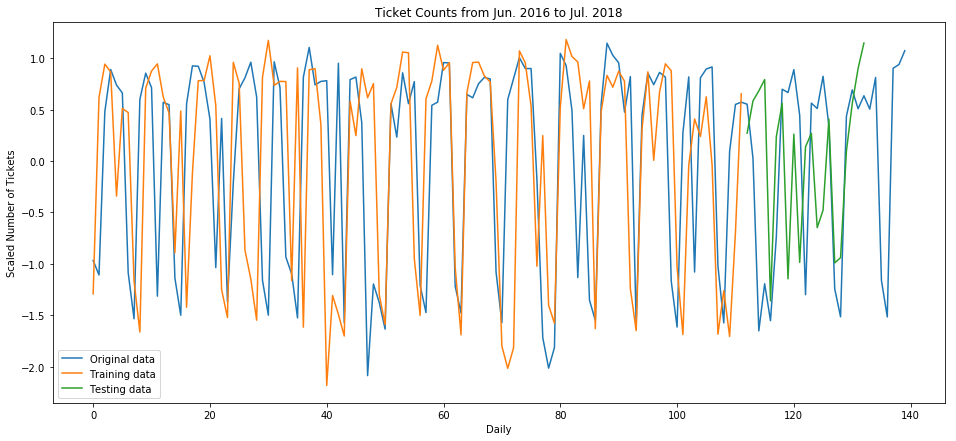

In [78]:
#we now plot predictions from the network
plt.figure(figsize=(16, 7))
plt.title('Ticket Counts from Jun. 2016 to Jul. 2018')
plt.xlabel('Daily')
plt.ylabel('Scaled Number of Tickets')
plt.plot(scaled_data, label='Original data')
plt.plot(sup, label='Training data')
plt.plot(test_results, label='Testing data')
plt.legend()
plt.show()


## Calculate RMSE

In [106]:
test_data = [data for data in test_results if str(data) != 'None']
array = np.concatenate(test_data, axis=0)
test_data = array.flatten()

In [107]:
scaled_data2 = scaled_data[119:]
scaled_data2 = scaled_data2.flatten()

### Model RMSE

In [108]:
#original dataset and test dataset RMSE
mean_square_error = math.sqrt(mean_squared_error(scaled_data2, test_data))

In [109]:
mean_square_error

1.026789123717745

### Benchmark RMSE

In [113]:
benchmark = [0] * 21

In [114]:
#benchmark/baseline dataset and original dataset RMSE
#randomly choose the benchmark, for example: all 0s Compare with the LSTM model I had
mean_square_error2 = math.sqrt(mean_squared_error(scaled_data2, benchmark))

In [115]:
mean_square_error2

0.9012204800621411